## Homework #5. Behaviour exploration improvement
#### Author: `VLADYSLAVA TYTARENKO`
#### Total time spent on h/w (in minutes): `1180`

---

Аналіз зосереджено на групових чатах абітурієнтів з України, в яких нараховується понад 100 тисяч повідомлень. Для зручності дані розподілені на п'ять основних категорій та одну підкатегорію. Це:
- Загальна активність
- Емоційний стан
- Підготовка до вступу
- Процес вступу
- Теми обговорення
  - Мовне питання

In [1139]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
from collections import Counter
import numpy as np
import emoji
import warnings
warnings.filterwarnings('ignore')

In [1140]:
DIALOGS_DATA_PATH = "/Users/vladislavatitarenko/Desktop/mydata/dialogs"
DIALOGS_META_DATA_PATH = "/Users/vladislavatitarenko/Desktop/mydata/dialogs_meta"
universities_PATH = "/Users/vladislavatitarenko/Desktop/mydata/keywords/universities.txt" 
spec_PATH = "/Users/vladislavatitarenko/Desktop/mydata/keywords/spec.txt" 
tone_dict_PATH = "/Users/vladislavatitarenko/Desktop/mydata/keywords/tone-dict-uk-full.csv"
categ_path = "/Users/vladislavatitarenko/Desktop/mydata/keywords/categories.txt"
warwords_PATH = "/Users/vladislavatitarenko/Desktop/mydata/keywords/warwords.txt"

In [1141]:
df_list = []
for file_path in Path(DIALOGS_DATA_PATH).glob("*.csv"):
    data = pd.read_csv(file_path)
    df_list.append(data)
df = pd.concat(df_list, ignore_index=True)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# **ЗАГАЛЬНА АКТИВНІСТЬ** 

## 1. Динаміка повідомлень у чатах за місяцями

In [1144]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

monthly_message_counts = df.groupby(['year', 'month']).size().reset_index(name='message_count')

monthly_message_counts['month_name'] = monthly_message_counts['month'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%B'))

df_pivot = monthly_message_counts.pivot_table(index='month_name', columns='year', values='message_count', aggfunc='sum')
df_pivot = df_pivot.reindex(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])

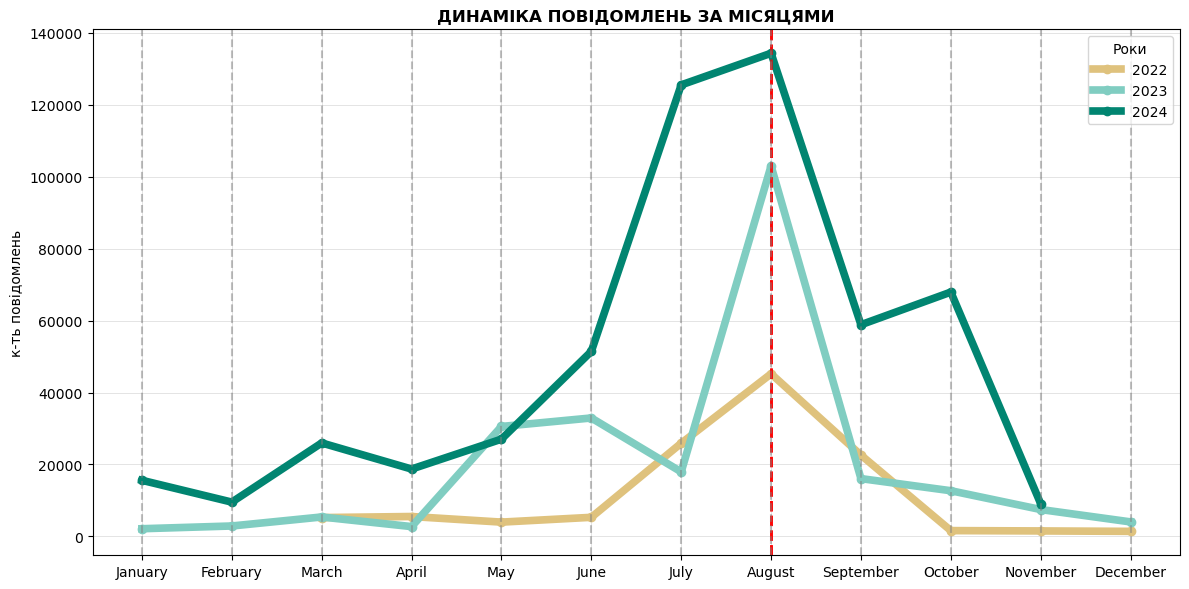

In [1553]:
plt.figure(figsize=(12, 6))

colors = ["#dfc27d", "#80cdc1", "#018571"]

for idx, year in enumerate(df_pivot.columns): 
    plt.plot(df_pivot.index, df_pivot[year], marker='o', label=f'{year}', color=colors[idx], linewidth=5.5)

    max_value = df_pivot[year].max()
    max_index = df_pivot[year].idxmax()
    
    plt.axvline(x=max_index, color="red", linestyle='--', linewidth=2, alpha=0.7)

for x_pos in range(len(df_pivot.index)):
    plt.axvline(x=x_pos, color='gray', linestyle='--', alpha=0.5)

plt.grid(True, which='both', axis='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)


plt.ylabel('К-ть повідомлень')
plt.title('ДИНАМІКА ПОВІДОМЛЕНЬ ЗА МІСЯЦЯМИ', fontweight='bold')
plt.legend(title="Роки", fontsize=10)
plt.tight_layout()

**ВИСНОВОК:** Найвища активність у чатах абітурієнтів спостерігається в серпні (глобальний максимум на графіці), що відповідає очікуванням, оскільки саме в цей період завершується подача заяв до вищих навчальних закладів. Це спричиняє значне збільшення запитів та зацікавленості серед абітурієнтів щодо університетів, на які вони подали заяви.

## 2. Динаміка активності учасників у чатах

In [1148]:
from_id_messages = df.groupby('from_id')['date'].min().reset_index()

from_id_messages['month'] = from_id_messages['date'].dt.to_period('M')  

new_from_id_by_month = from_id_messages['month'].value_counts().sort_index()

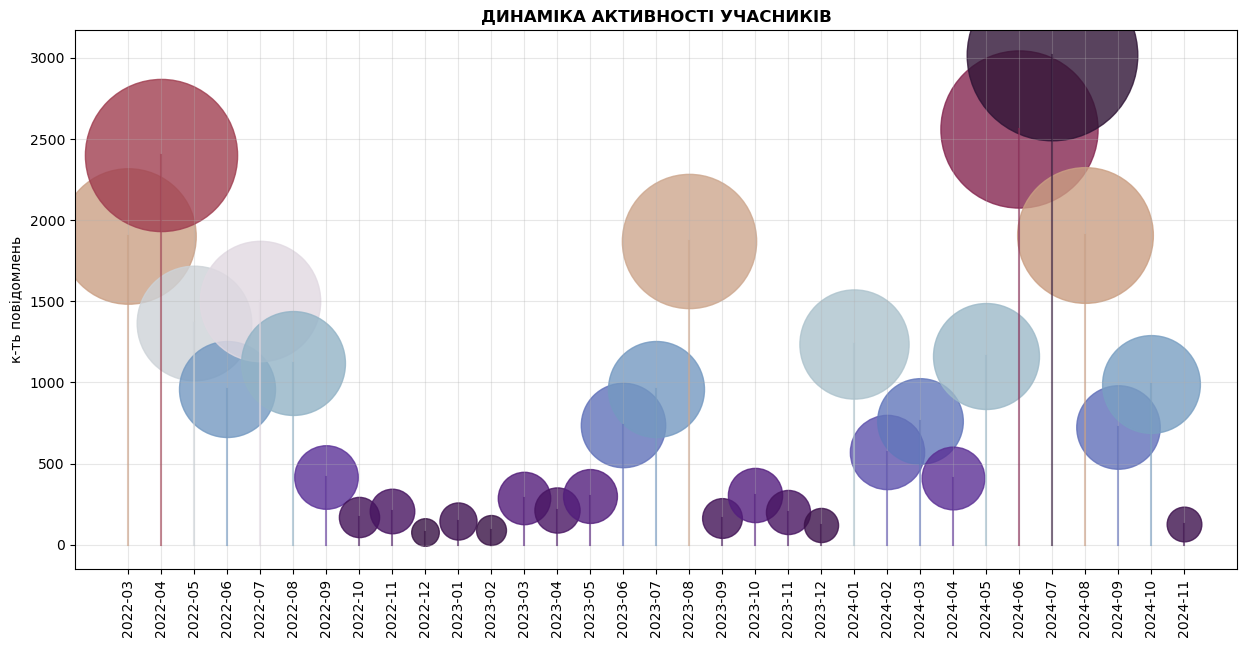

In [1551]:
plt.figure(figsize=(15, 7))

colors = plt.cm.twilight_shifted(new_from_id_by_month.values / max(new_from_id_by_month.values)) 

sizes = new_from_id_by_month.values * 5  
for i, value in enumerate(new_from_id_by_month.values):
    plt.scatter(new_from_id_by_month.index.astype(str)[i], value, s=sizes[i], c=[colors[i]], alpha=0.8)
    
    plt.plot([new_from_id_by_month.index.astype(str)[i], new_from_id_by_month.index.astype(str)[i]], [0, value], 
             color=colors[i], alpha=0.6)

plt.title("ДИНАМІКА АКТИВНОСТІ УЧАСНИКІВ", fontweight='bold')
plt.ylabel("К-ть повідомлень")
plt.xticks(rotation=90)
plt.grid(alpha=0.3)

**ВИСНОВОК:**  Вищенаведений графік аналізує приєднання до дискусій нових учасників і в які місяці це відбувається найбільш активно: 
- квітень 2022 року (новина про впровадження НМТ);
- серпень 2023 року (наступний етап вступної кампанії)
- червень, липень, серпень 2024 року (аналогічно з пунктом вище)

## 3. Динаміка активності учасників за днями тижня

In [1152]:
df['day_of_week'] = df['date'].dt.dayofweek

In [1153]:
activity_by_day = df.groupby('day_of_week').size()

days_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
activity_by_day.index = activity_by_day.index.map(days_mapping)

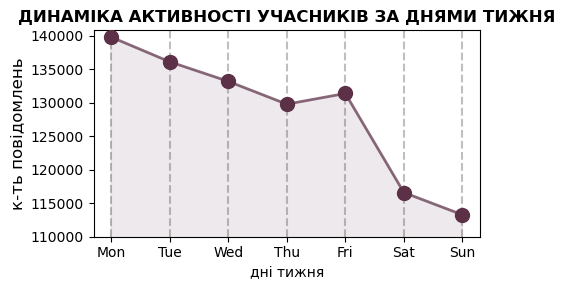

In [1154]:
plt.figure(figsize=(5, 3))

plt.scatter(activity_by_day.index, activity_by_day.values, color='#5c3047', s=100, marker='o', zorder=5)

plt.plot(activity_by_day.index, activity_by_day.values, color='#5c3047', linewidth=2, alpha=0.7, zorder=4)

for i in range(len(activity_by_day)):
    plt.axvline(x=i, color='gray', linestyle='--', alpha=0.5)

plt.fill_between(activity_by_day.index, activity_by_day.values, color='#5c3047', alpha=0.1, zorder=3)

plt.ylim(110000, max(activity_by_day.values)+1000)

plt.title("ДИНАМІКА АКТИВНОСТІ УЧАСНИКІВ ЗА ДНЯМИ ТИЖНЯ", fontweight='bold')
plt.xlabel("Дні тижня", fontsize=10)
plt.ylabel("К-ть повідомлень", fontsize=12)

# Покращення вигляду
plt.tight_layout()

# Показати графік
plt.show()


In [1155]:
print(activity_by_day.to_string())

day_of_week
Mon    139771
Tue    136085
Wed    133168
Thu    129765
Fri    131355
Sat    116588
Sun    113268


**ВИСНОВОК:** Найменшу кількість повідомлень пишуть у неділю, далі — у суботу, що свідчить про знижену активність користувачів у ці дні тижня. Можна припустити, що це пов'язано з тим, що в ці дні учасники більше фокусуються на відпочинку чи особистих справах, а не на активному спілкуванні в чатах.

## 4. Динаміка активності учасників за добу

In [1158]:
hourly_activity = [0] * 24

In [1159]:
for timestamp in df['date'].dropna():
    hour = timestamp.hour  
    hourly_activity[hour] += 1 

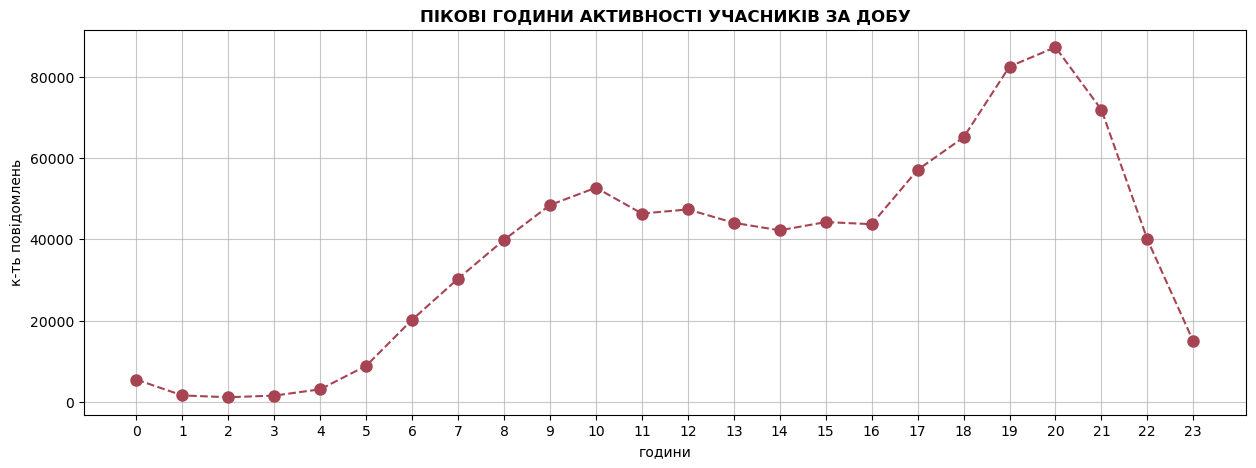

In [1160]:
plt.figure(figsize=(15, 5))
hours = range(24)  
plt.plot(hours, hourly_activity, marker='o', color='#a64453', linestyle='--', markersize=8)

plt.title('ПІКОВІ ГОДИНИ АКТИВНОСТІ УЧАСНИКІВ ЗА ДОБУ', fontweight='bold')
plt.xlabel('Години')
plt.ylabel('К-ть повідомлень')
plt.xticks(hours)
plt.grid(alpha=0.7)

**ВИСНОВОК:** Глобальний максимум активності в чатах абітурієнтів припадає на 8 вечора. Це можна пояснити тим, що цей час є найбільш зручним для спілкування: завершується основна частина занять, пов'язаних зі школою чи підготовкою до вступу, і з’являється більше вільного часу для участі в дискусіях.

---

# **ПІДГОТОВКА ДО ВСТУПУ**

## 5. Згадки учасниками предметів з НМТ

In [1519]:
subjects = {
    "математика": r"\bмат(ематика|ем|)\b",
    "українська мова": r"\bукр(аїнська мова|мова|)\b",
    "історія України": r"\bістор(ія|ія України)\b",
    "англійська": r"\bангл(ійська|)\b",
    "фізика": r"\bфіз(ика|)\b",
    "хімія": r"\bхім(ія|)\b",
    "біологія": r"\bбіол(огія|)\b",
    "географія": r"\bгеогр(афія|)\b",
}
subject_counts = {subject: 0 for subject in subjects}

file_subject_counts = {}

In [1521]:
all_text = ' '.join(data.astype(str).apply(lambda row: ' '.join(row), axis=1)).lower()

AttributeError: 'list' object has no attribute 'astype'

In [1523]:
        file_count = {subject: 0 for subject in subjects}

        for subject, regex in subjects.items():
            count = len(re.findall(regex, all_text))
            subject_counts[subject] += count
            file_count[subject] = count

        file_subject_counts[file_path] = file_count

sorted_subject_counts = dict(sorted(subject_counts.items(), key=lambda item: item[1], reverse=True))

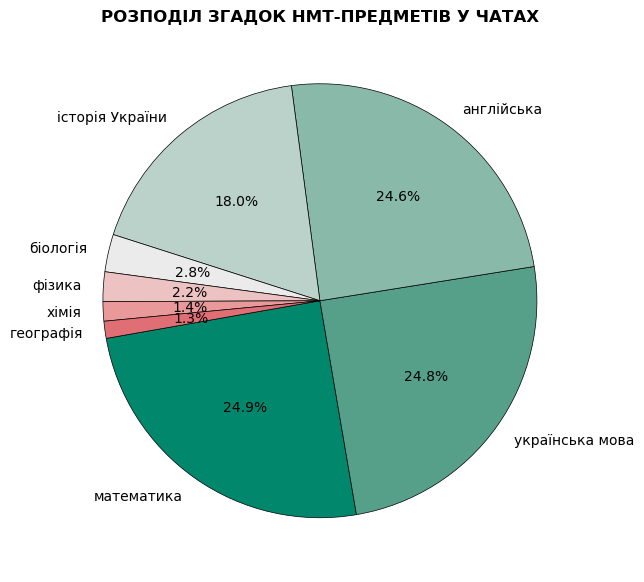

In [1531]:
colors = ['#00876c', '#56a08a', '#89b9a9', '#bad2ca', 
          '#ebebeb', '#ecc2c2', '#e9999a', '#e06f75']
plt.figure(figsize=(7, 9))
plt.pie(
    sorted_subject_counts.values(),
    labels=sorted_subject_counts.keys(),
    autopct='%1.1f%%',  
    startangle=190,  
    colors=colors,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}
)
plt.title('РОЗПОДІЛ ЗГАДОК НМТ-ПРЕДМЕТІВ У ЧАТАХ', fontweight='bold')
plt.show()

**ВИСНОВОК:** Математика є найбільш згадуваним предметом, після чого йдуть українська мова, англійська та історія. Це є очікуваним, оскільки перші два предмети, а також історія, є обов'язковими для складання НМТ. Також можна побачити пріоритети абітурієнтів щодо обраних предметів, і найпопулярнішою серед них залишається англійська мова. Найменша кількість згадок про географію пояснюється тим, що у 2022 та 2023 роках цей предмет не був доступний для вибору при складанні НМТ.

## 6. Згадки учасниками балів НМТ 

При додатковому аналізі найпоширеніших слів у чатах було помічено часту вживаність округлених балів НМТ (150, 180 і т.п.). Тому було вирішено провести аналіз за кількома напрямками: 
а) які бали найчастіше згадують абітурієнти,
б) на які бали складають НМТ абітурієнти,
в) новини від МОН, в яких згадуються бали НМТ (як порогові та інші).

Це дозволить поєднати всі ці аспекти в один графік для чіткішого аналізу.

In [1507]:
search_nmt_phrases = ["110", "120", "130", "140", "150",
                  "160", "170", "180", "190", "200"]
word_nmt_counts = {phrase: 0 for phrase in search_nmt_phrases}

In [1509]:
if 'message' in df.columns:
    df['message'] = df['message'].apply(lambda x: re.sub(r'[^\w\s-]', '', str(x).lower()))

In [1511]:
for message in df['message']:
    for phrase in search_nmt_phrases:
        if phrase in message:
            word_nmt_counts[phrase] += 1

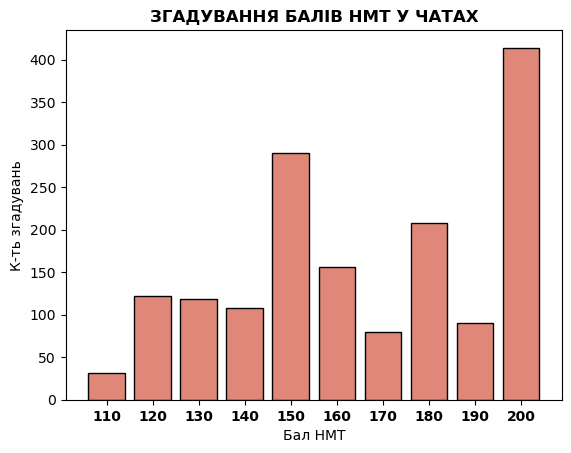

In [1517]:
plt.bar(word_nmt_counts.keys(), word_nmt_counts.values(), color= "#df8879", edgecolor='black')

plt.title('ЗГАДУВАННЯ БАЛІВ НМТ У ЧАТАХ', fontweight='bold')
plt.xlabel('Бал НМТ')
plt.ylabel('К-ть згадувань')
plt.xticks(fontweight='bold')
plt.show()

**ВИСНОВОК:** 200 та 150 балів є найпоширенішими балами у обговореннях серед абітурієнтів. 150 балів, у свою чергу, є мінімальним порогом для отримання гранту, що робить його важливою метою для багатьох вступників. Така частота може свідчити про значну кількість випускників, які орієнтуються саме на цей мінімум, щоб отримати можливість навчатися безоплатно. Це також може бути пов'язано з доступністю завдань або загальною складністю тесту.

## 7. Згадки учасниками форм навчання за роками

Посилаючись на додатковий аналіз найпоширеніших слів (який не було включено до підкатегорії цього дослідження), можна відзначити, що форми навчання, такі як бюджетна, контрактна та гранти, часто згадувалися учасниками в обговореннях. Це є важливим для оцінки орієнтованості абітурієнтів на певну форму навчання та кореляції загального рівня підготовки з отриманими балами (п. 6), які дають можливість вступити на одну з наведених форм навчання. 

In [1499]:
search_words = ["бюджет", "контракт", "грант"]
search_words = [word.lower() for word in search_words]

monthly_counts = {word: {2022: [0] * 12, 2023: [0] * 12, 2024: [0] * 12} for word in search_words}

In [1501]:
df['message'] = df['message'].apply(lambda x: re.sub(r'[^\w\s-]', '', str(x).lower()))

In [1503]:
for _, row in df.iterrows():
    message = row['message']
    timestamp = row['date']

    if pd.notnull(timestamp):
        year = timestamp.year
        month = timestamp.month - 1  # Для списку (0-11)
    if year in [2022, 2023, 2024]:
      for word in search_words:
        if word in message:
          monthly_counts[word][year][month] += 1

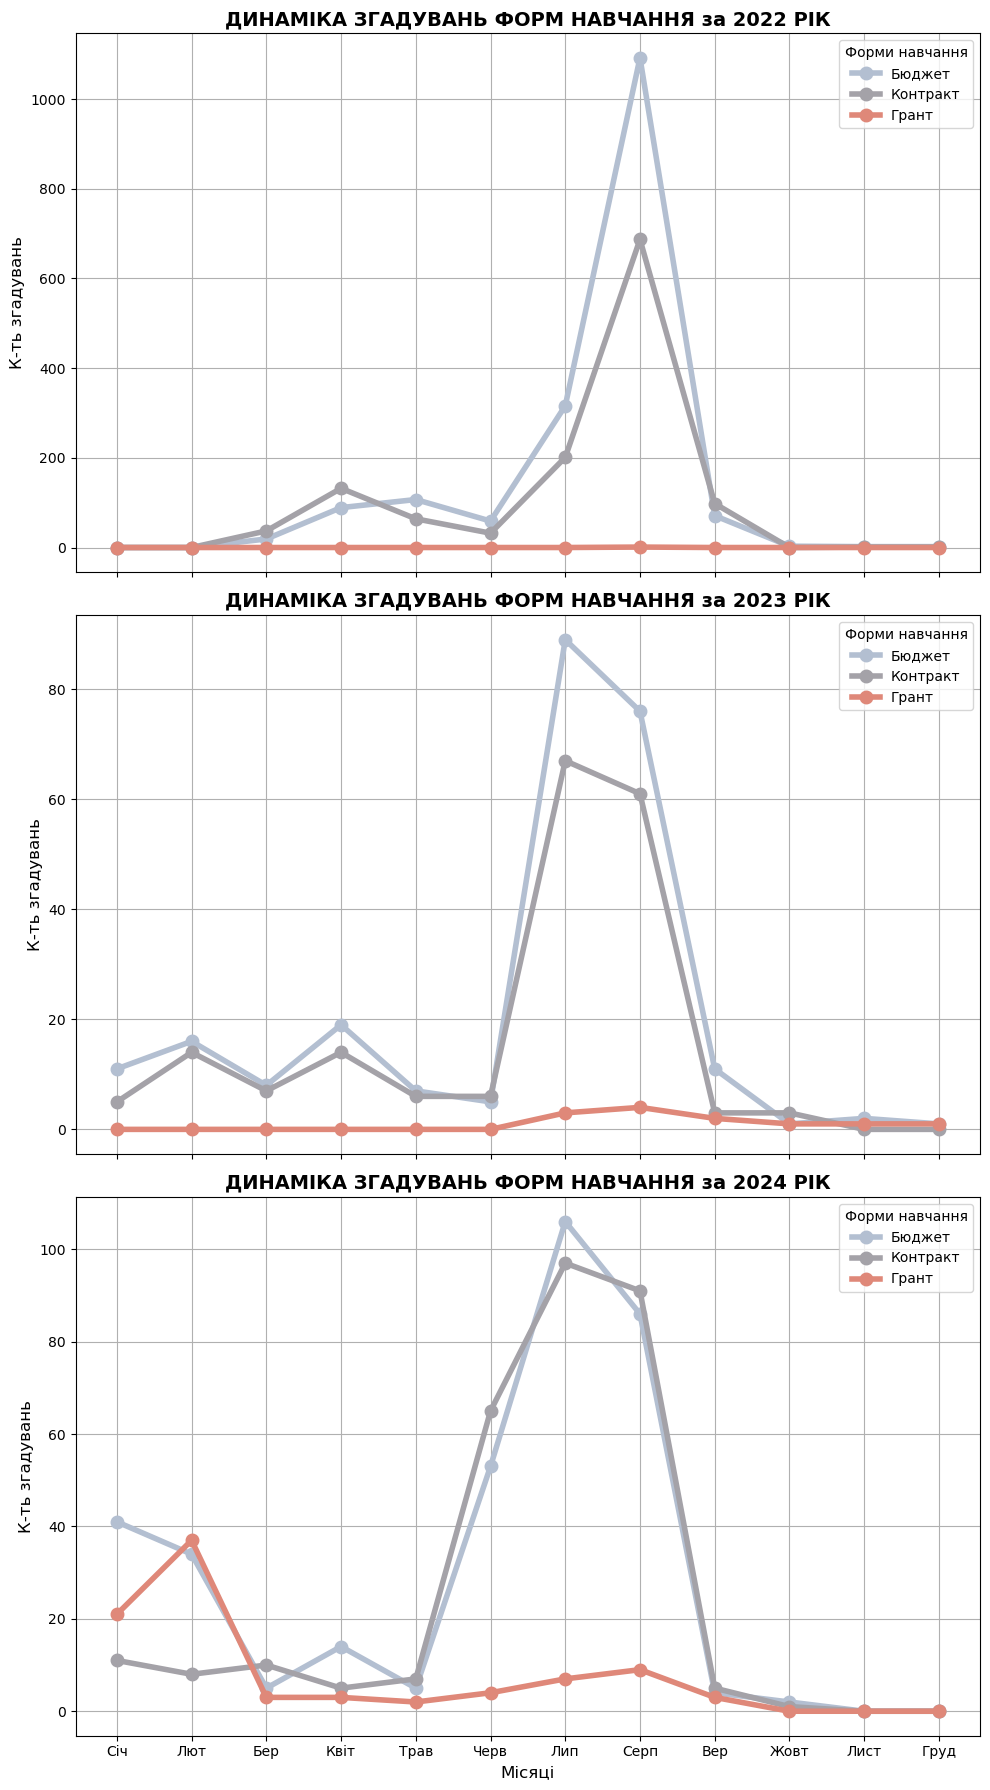

In [1549]:
colors = ["#b3bfd1", "#a4a2a8", "#df8879"]

fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

years = [2022, 2023, 2024]

color_map = {search_words[i]: colors[i] for i in range(len(search_words))}

# Побудова підграфіків для кожного року
for idx, year in enumerate(years):
    ax = axes[idx]
    for word in search_words:
        ax.plot(
            range(1, 13), 
            monthly_counts[word][year], 
            label=word.capitalize(), 
            linewidth=4, 
            color=color_map[word],  # Використовуємо правильний колір для слова
            marker='o',  
            markersize=8,  
            markerfacecolor=color_map[word],  
            markeredgewidth=2  
        )

    ax.set_title(f'ДИНАМІКА ЗГАДУВАНЬ ФОРМ НАВЧАННЯ за {year} РІК', fontsize=14, fontweight='bold')
    ax.set_ylabel('К-ть згадувань', fontsize=12)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Січ', 'Лют', 'Бер', 'Квіт', 'Трав', 'Черв', 'Лип', 'Серп', 'Вер', 'Жовт', 'Лист', 'Груд'])
    ax.legend(title='Форми навчання', fontsize=10)
    ax.grid(True)

axes[-1].set_xlabel('Місяці', fontsize=12)

plt.tight_layout()
plt.show()

**ВИСНОВОК:** Помітна різниця в орієнтованості учасників на навчання за бюджетною формою у 2022 і 2023 роках: в 2022 році абітурієнти приблизно в 1,5 рази частіше згадували саме її, порівняно з 2023 роком. Це можна пояснити полегшеною формою тестування через впровадження НМТ, тоді як у 2023 році поступово почали відновлювати ускладнені завдання.

У 2024 році лінія, що відображає згадування грантової форми навчання, починає зростати під час вступу (липень-серпень). Це пов'язано з новим законом МОН щодо фінансової підтримки студентів через гранти. Тому контрактна форма навчання знову поступається бюджетній, оскільки більшість абітурієнтів орієнтована на подання заяв на бюджетну або грантову форми навчання.

## 8. Згадки КВОТА-1 / КВОТА-2 за роками

Це питання виникло на підставі зростання кількості вступників з КВОТОЮ-2 після повномасштабного вторгнення в Україну 24 лютого 2022 року. За спостереженнями та опитуваннями знайомих, до 2022 року абітурієнти мали обмежене знання щодо умов та можливостей отримання пільг при вступі. Тому важливим є порівняння даних щодо згадувань про пільги між 2022 і наступними роками, щоб оцінити зміну обізнаності та інтересу серед вступників.
### _Наскільки зросло згадування пільг при вступі порівняно з 2022 роком?_ 

In [1186]:
search_kv_phrases = ["квота-1", "квота-2"]
search_kv_phrases = [phrase.lower() for phrase in search_kv_phrases]

yearly_counts = {phrase: {2022: 0, 2024: 0} for phrase in search_kv_phrases}

In [1187]:
df['combined_text'] = df.astype(str).apply(lambda row: ' '.join(row), axis=1)

In [1188]:
 for _, row in df.iterrows():
            timestamp = row['date']
            if pd.notnull(timestamp):
                year = timestamp.year
                if year in yearly_counts[search_kv_phrases[0]]:  # Обмеження на роки 2022 і 2024
                    for phrase in search_kv_phrases:
                        yearly_counts[phrase][year] += str(row['combined_text']).lower().count(phrase)

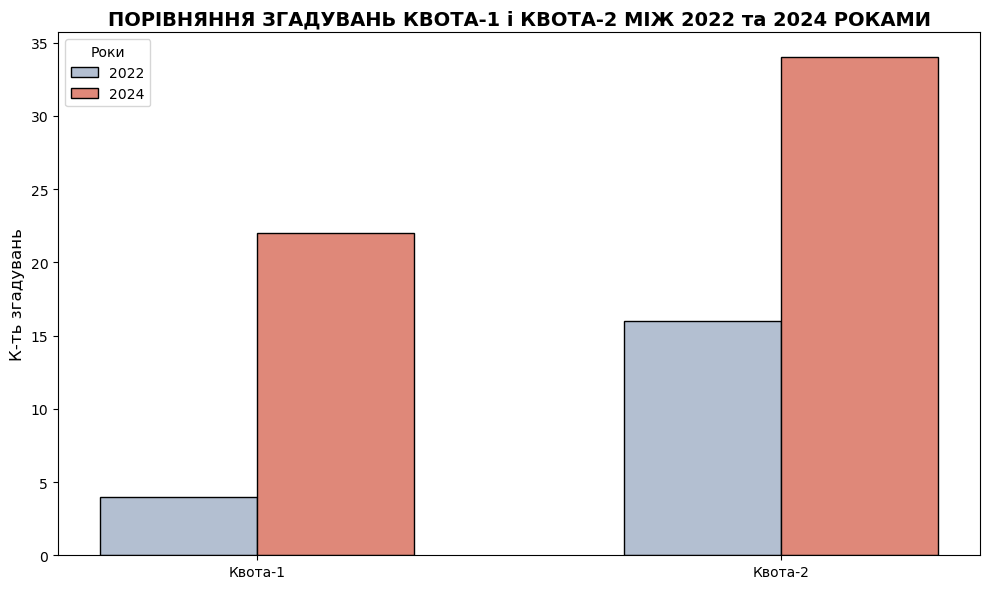

In [1547]:
labels = search_kv_phrases  
years = [2022, 2024]
x = range(len(labels))  

fig, ax = plt.subplots(figsize=(10, 6))

# Дані для графіка
bar_width = 0.3
colors = ["#b3bfd1", "#df8879"]  

for idx, year in enumerate(years):
    counts = [yearly_counts[phrase][year] for phrase in labels]
    ax.bar([pos + idx * bar_width - bar_width / 2 for pos in x], counts, bar_width, label=f"{year}", color=colors[idx], edgecolor='black')

ax.set_ylabel('К-ть згадувань', fontsize=12)
ax.set_title('ПОРІВНЯННЯ ЗГАДУВАНЬ КВОТА-1 і КВОТА-2 МІЖ 2022 та 2024 РОКАМИ', fontsize=14, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels([phrase.capitalize() for phrase in labels])  

ax.legend(title="Роки", fontsize=10)

plt.tight_layout()
plt.show()

**ВИСНОВОК:** Спостерігається явна тенденція зростання згадувань в обговореннях абітурієнтами щодо пільг при вступі між 2022 та 2024 роками. Зокрема, згадування про КВОТА-1 зросло в 4,5 рази, а про КВОТА-2 — в 2 рази. Цей графік підтверджує припущення, що після повномасштабного вторгнення більша кількість абітурієнтів дізналася (і продовжує дізнаватися) про таку можливість, що особливо помітно в зростанні запитів щодо КВОТА-1.

---

# **ЕМОЦІЙНИЙ СТАН**

## 9. Тональність учасників чату

Для визначення періоду з найвищим рівнем негативної тональності використано словник тональності українських слів, де значення "-2" позначає найбільш негативну тональність, а "2" - найбільш позитивну.
### _В який період вступної кампанії рівень негативної тональності найвищий?_

In [1195]:
tone_dict = pd.read_csv(tone_dict_PATH, index_col='word')

In [1196]:
df_2023 = df[df['date'].dt.year == 2023]

In [1197]:
def calculate_tone_score(text, tone_dict):
    if isinstance(text, str):  # Перевірка, чи є текст рядком
        words = text.split()
        tone_score = sum(tone_dict.loc[word, 'sentiment'] for word in words if word in tone_dict.index)
        return tone_score
    else:
        return 0

In [1198]:
df_2023 = df_2023.copy()
df_2023['tone_score'] = df_2023['message'].apply(lambda x: calculate_tone_score(x, tone_dict))
df_2023['month'] = df_2023['date'].dt.month

monthly_tone = df_2023.groupby('month')['tone_score'].mean()

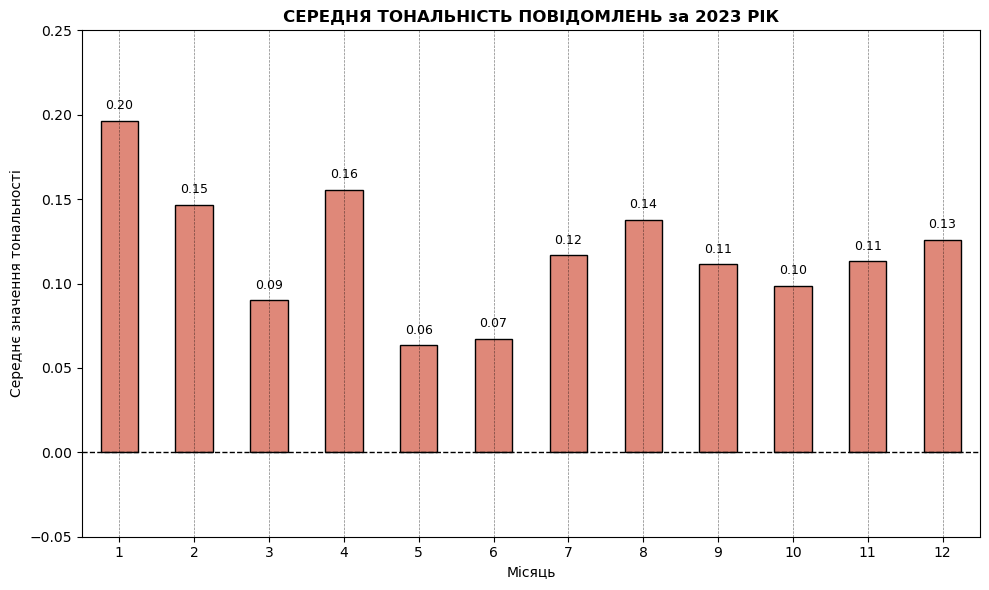

In [1578]:
plt.figure(figsize=(10, 6))

monthly_tone.plot(kind='bar', color='#df8879', edgecolor='black')

plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.ylim(-0.05, 0.25)
plt.title('СЕРЕДНЯ ТОНАЛЬНІСТЬ ПОВІДОМЛЕНЬ за 2023 РІК', fontweight='bold')
plt.xlabel('Місяць')
plt.ylabel('Середнє значення тональності')

plt.xticks(rotation=0)

plt.grid(True, which='both', axis='x', color='black', linestyle='--', linewidth=0.5, alpha=0.5)
for index, value in enumerate(monthly_tone):
    plt.text(index, value + 0.005, f'{value:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

 > Пояснення до графіку: досліджується середня тональність повідомлень учасників протягом 2023 року, оскільки дані за 2022 та 2024 роки не були б настільки цілісними. Чим ближче значення до нуля, тим більш негативною є тональність, що і є метою цього аналізу.

**ВИСНОВОК:** За графіком травень виявляється місяцем з найбільш негативною тональністю порівняно з іншими місяцями року, далі йдуть червень, березень та жовтень. У середині травня (або червні) розпочинаються іспити у випускників, що, ймовірно, є основною причиною негативних емоцій в цей період.

Цей аналіз дозволяє визначити період, коли у абітурієнтів домінують емоції негативної тональності, такі як сум, розчарування, гнів, страх тощо. Таким чином, можна підсумувати, що період вступної кампанії — зокрема, час написання іспитів — є найемоційнішим для підлітків протягом року.

## 10. Рівень стресу серед учасників чатів

Як продовження п.9, проаналізуємо рівень стресу серед учасників чату, зокрема, чи збігається стресовий стан з періодом написання іспитів, чи припадає на наступні етапи вступної кампанії. 

In [1204]:
stress_keywords = [
    "переживання", "не здам", "не складу", "хвилювання", "паніка", "стрес", "не можу", "проблема",
    "нервую", "боюсь", "страшно", "не знаю", "важко", "тяжко", "втома",
    "заплутався", "здаюсь", "не виходить", "сумно", "сум", "розчарування",
    "сльози", "нервовий", "тривога", "невпевненість", "плач",
    "погано", "провал", "вибачте", "забув", "дедлайн",
    "встигнути", "запізнююсь", "зіпсувалося",
    "хочу здатися", "нервую через", "хто допоможе", "як впоратися", "не знаю що робити",
    "помилка", "помилявся", "неправильно", "вибачте за помилку", "занадто складно",
    "перевтома", "вичерпався", "сили немає", "проблеми з", "зламалося",
    "засмутився", "розчарувався", "нічого не вийде", "знову не встиг"
]

In [1205]:
def contains_stress_keywords(message, keywords):
    if pd.isnull(message):
        return False
    for word in keywords:
        if re.search(rf"\b{word}\b", message, re.IGNORECASE):
            return True
    return False

In [1206]:
from collections import defaultdict
monthly_stress = defaultdict(int)

In [1207]:
df['is_stress'] = df['message'].apply(lambda x: contains_stress_keywords(x, stress_keywords))

In [1208]:
df['month'] = df['date'].dt.to_period('M')

In [1209]:
stress_counts = df[df['is_stress']].groupby('month').size()
for month, count in stress_counts.items():
    monthly_stress[month] += count

In [1210]:
monthly_stress_df = pd.DataFrame(list(monthly_stress.items()), columns=['Month', 'StressCount'])
monthly_stress_df = monthly_stress_df.sort_values('Month')

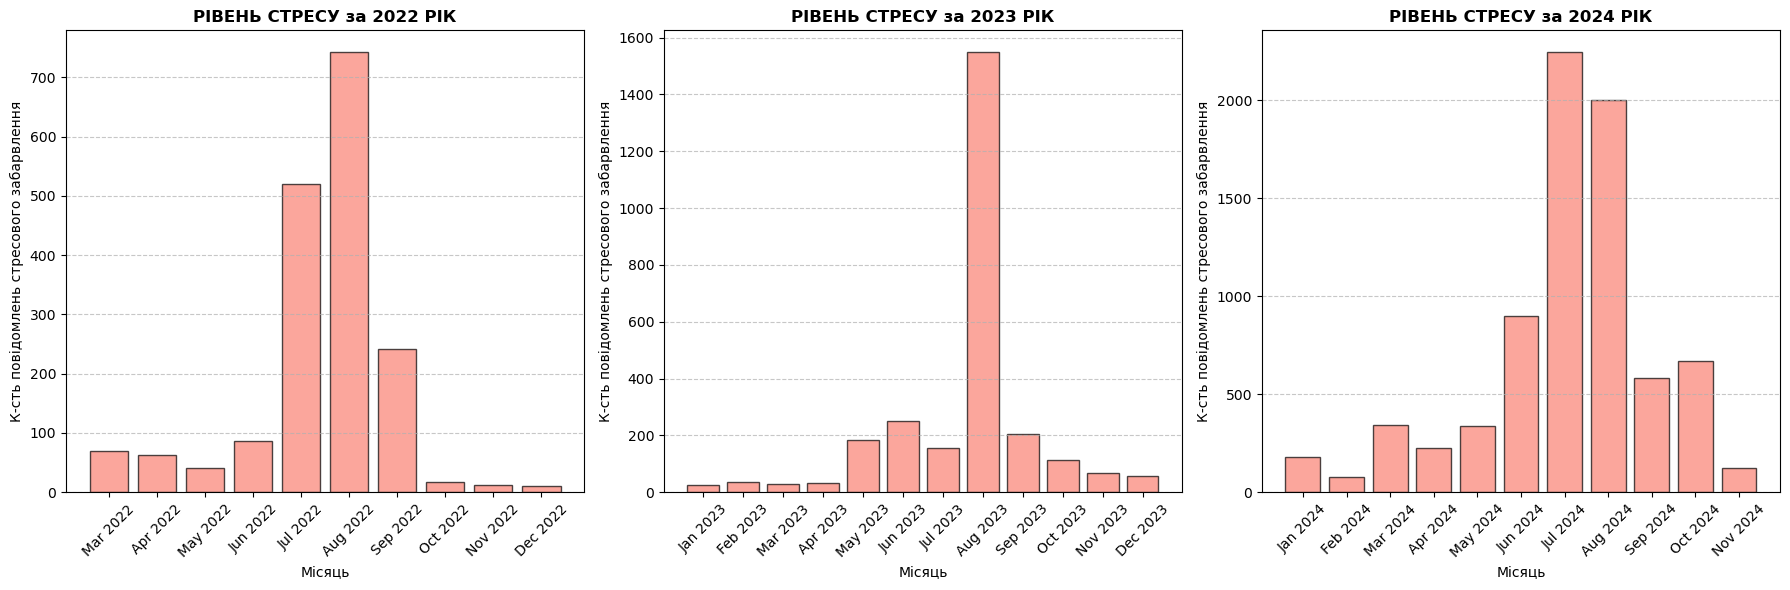

In [1580]:
years = [2022, 2023, 2024]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for ax, year in zip(axs, years):
    year_data = monthly_stress_df[monthly_stress_df['Month'].dt.year == year]
    ax.bar(year_data['Month'].astype(str), year_data['StressCount'], color='salmon', edgecolor='black', alpha=0.7)
    ax.set_title(f'РІВЕНЬ СТРЕСУ за {year} РІК', fontweight='bold')
    ax.set_xlabel('Місяць')
    ax.set_ylabel('К-ть повідомлень стресового забарвлення')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_xticks(range(len(year_data['Month'])))
    ax.set_xticklabels(year_data['Month'].dt.strftime('%b %Y'), rotation=45)

plt.tight_layout()
plt.show()

**ВИСНОВОК:** Липень і серпень визначаються як найбільш стресові місяці для абітурієнтів протягом вступної кампанії, що підтверджується їх присутністю у трьох підграфіках. Це дозволяє зробити висновок, що у травні-червні (період написання іспитів) вступники переживають негативні емоції, зокрема гнів, що є природною реакцією з психологічної точки зору (п.9). У той час як липень-серпень (період подання заяв до університетів) супроводжується виснаженням та переживаннями.

## 11. Найуживаніші емодзі у чаті

In [1214]:
excluded_emojis = {'🎈'} #Виявився ніком користувача 

In [1215]:
def extract_emojis(text):
    return [char for char in text if char in emoji.EMOJI_DATA]

In [1216]:
all_data = []

for file in os.listdir(DIALOGS_DATA_PATH):
    if file.endswith('.csv'):
        file_path = os.path.join(DIALOGS_DATA_PATH, file)
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['date'])
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.to_period('M')  
        df['emojis'] = df['message'].apply(lambda x: [e for e in extract_emojis(str(x)) if e not in excluded_emojis]) 
        all_data.append(df)

combined_df = pd.concat(all_data, ignore_index=True)

In [1217]:
combined_df_2024 = combined_df[combined_df['year'] == 2024]

emojis_by_month_2024 = combined_df_2024.groupby('month')['emojis'].apply(lambda x: [emo for sublist in x for emo in sublist])

most_common_by_month_2024 = emojis_by_month_2024.apply(lambda ems: Counter(ems).most_common(1))

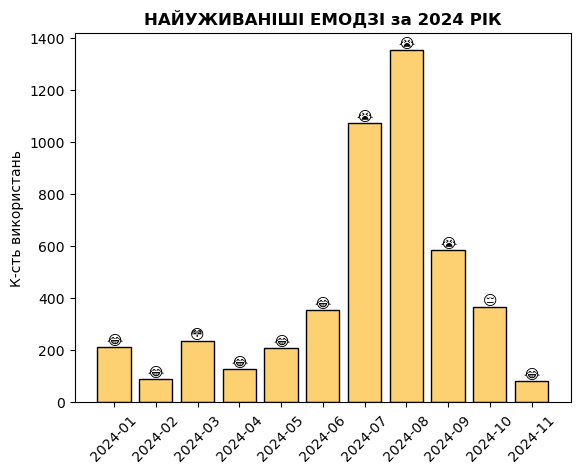

In [1582]:
emoji_df_2024 = pd.DataFrame([(month, data[0][0], data[0][1]) for month, data in most_common_by_month_2024.items()],
                             columns=['Month', 'Emoji', 'Count'])

plt.bar(emoji_df_2024['Month'].astype(str), emoji_df_2024['Count'], color='#fdd072', edgecolor='black')
for i, row in emoji_df_2024.iterrows():
    plt.text(i, row['Count'] + 10, row['Emoji'], ha='center')  
    
plt.title('НАЙУЖИВАНІШІ ЕМОДЗІ за 2024 РІК', fontweight='bold')
plt.ylabel('К-ть використань')
plt.xticks(rotation=45)
plt.show()

In [1219]:
print("Найпопулярніші емодзі по місяцях за 2024 рік:")
for month, data in most_common_by_month_2024.items():
    emoji, count = data[0]  
    print(f"Місяць: {month}, Найуживаніший емодзі: {emoji}")

Найпопулярніші емодзі по місяцях за 2024 рік:
Місяць: 2024-01, Найуживаніший емодзі: 😂
Місяць: 2024-02, Найуживаніший емодзі: 😂
Місяць: 2024-03, Найуживаніший емодзі: 😳
Місяць: 2024-04, Найуживаніший емодзі: 😂
Місяць: 2024-05, Найуживаніший емодзі: 😂
Місяць: 2024-06, Найуживаніший емодзі: 😂
Місяць: 2024-07, Найуживаніший емодзі: 😭
Місяць: 2024-08, Найуживаніший емодзі: 😭
Місяць: 2024-09, Найуживаніший емодзі: 😭
Місяць: 2024-10, Найуживаніший емодзі: 😔
Місяць: 2024-11, Найуживаніший емодзі: 😂


**ВИСНОВОК:** Найвиразнішими емодзі, що відображають емоційний стан абітурієнтів, є "😳" та "😭", які переважають у березні та серпні відповідно. Можна провести кореляцію між цими емодзі та подіями, що відбуваються в ці місяці: у березні, коли МОН публікує інформацію про проведення іспитів та впроваджує нові освітні закони, часто з’являється емодзі, що виражає здивування ("😳"). В серпні, коли вступна кампанія досягає свого піку і абітурієнти переживають значний стрес, переважає емодзі, що виражає смуток ("😭").

# **ПРОЦЕС ВСТУПУ**

## 12. Популярність спеціальностей 12 галузі

Серед найпоширеніших повідомлень в чатах абітурієнтів зустрічалися номери спеціальностей, зокрема 121 та 122. Оскільки ці спеціальності є популярними серед вступників та актуальними в контексті сучасних вимог на ринку праці, було вирішено провести аналіз попиту на кожну IT-спеціальність. Це дозволить визначити, яких фахівців в Україні буде більше, а яких — менше, що, у свою чергу, дасть змогу коригувати кількість місць на відповідних спеціальностях, зменшуючи їх у тих сферах, де попит менший, і збільшуючи у тих, де очікується високий попит на фахівців.

In [1224]:
search_itphrases = ["121", "122", "123", "124", "125", "126"]
search_itphrases = [phrase.lower() for phrase in search_itphrases]

itword_counts = {phrase: 0 for phrase in search_itphrases}

In [1225]:
for message in df['message']:
    if isinstance(message, str): 
        for phrase in search_itphrases:
            if phrase in message:
                itword_counts[phrase] += 1

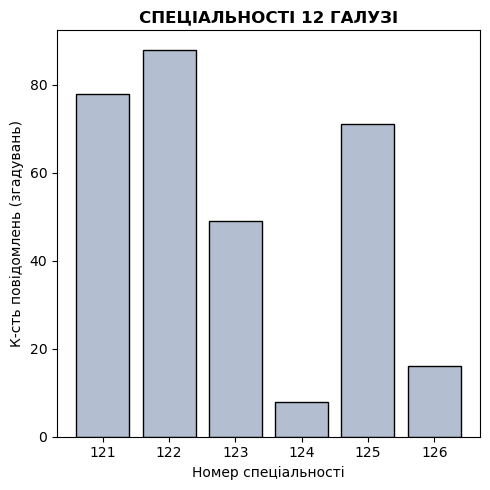

In [1586]:
plt.figure(figsize=(5, 5))
plt.bar(itword_counts.keys(), itword_counts.values(), color='#b3bfd1',edgecolor='black')

plt.title('СПЕЦІАЛЬНОСТІ 12 ГАЛУЗІ',fontweight='bold')
plt.xlabel('Номер спеціальності')
plt.ylabel('К-ть повідомлень (згадувань)')
plt.tight_layout()

plt.show()

**ВИСНОВОК:** До трійки найпопулярніших спеціальностей у галузі 12 (Інформаційні технології) входять 122 "Комп'ютерні науки", 121 "Інженерія програмного забезпечення" та 125 "Кібербезпека". Варто зазначити, що в НаУКМА на факультеті інформатики пропонують саме ці три спеціальності, що свідчить про їх високу популярність серед абітурієнтів. Це може свідчити про те, що університет адаптується до попиту на ці спеціальності. Водночас, спеціальності 126 "Інформаційні системи та технології" та 124 "Системний аналіз" не набрали популярності в обговореннях серед вступників, що підтверджується низьким рівнем їх згадуваності в чатах.

## 13. Порівняння: статистика заяв до університетів / згадування в чатах

In [1423]:
search_uni_phrases = {}

In [1425]:
with open(universities_PATH, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        if ':' in line.strip():
            key, phrases = line.strip().split(':', 1) 
            phrases_list = [phrase.strip() for phrase in phrases.split(',')]
            search_uni_phrases[key.strip()] = phrases_list  

In [1475]:
real_applications = {
    'ЛП': 45992/100,
    'КНУ': 44182/100,
    'ЛНУ': 44138/100,
    'КПІ': 35475/100,
    'ДТЕУ': 27122/100,
    'КНЕУ': 18884/100,
    'ЧНУ': 18706/100,
    'НАУ': 17990/100,
    'ПНУ': 17670/100,
    'НУБІП': 17180/100
}

In [1477]:
word_counts = {group: 0 for group in search_uni_phrases}

In [1479]:
word_counts = {group: 0 for group in search_uni_phrases}
for group, phrases in search_uni_phrases.items():
    for phrase in phrases:
        word_counts[group] += all_text.count(phrase.lower())


sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

final_counts = {}
for group, count in sorted_word_counts.items():
    final_counts[group] = {
        'Count': count,
        'Real Applications': real_applications.get(group, 0)
    }

sorted_final_counts = dict(sorted(final_counts.items(), key=lambda item: item[1]['Count'], reverse=True))

In [1480]:
university_names = list(sorted_final_counts.keys())
counts = [data['Count'] for data in sorted_final_counts.values()]
real_applications_counts = [data['Real Applications'] for data in sorted_final_counts.values()]

num_universities = len(university_names)

ind = np.arange(num_universities)
width = 0.35  

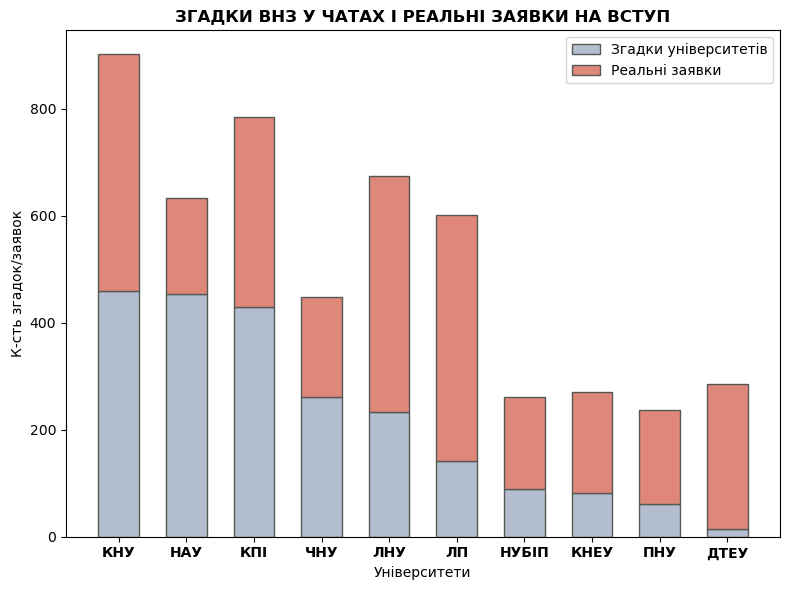

In [1495]:
fig, ax = plt.subplots(figsize=(8, 6))

ind = range(len(university_names))  
width = 0.6  

bars1 = ax.bar(ind, counts, width, label='Згадки університетів', color='#b3bfd1', edgecolor='#545955')
bars2 = ax.bar(ind, real_applications_counts, width, bottom=counts, label='Реальні заявки', color= "#df8879", edgecolor='#545955')

ax.set_xlabel('Університети')
ax.set_ylabel('К-ть згадок/заявок')
ax.set_title('ЗГАДКИ ВНЗ У ЧАТАХ І РЕАЛЬНІ ЗАЯВКИ НА ВСТУП', fontweight='bold')
ax.set_xticks(ind)
ax.set_xticklabels(university_names, fontweight='bold')

# Додавання легенди
ax.legend()

# Виведення графіка
plt.tight_layout()
plt.show()

> Пояснення до графіку: справжню кількість заяв можна визначити, помноживши значення графіка на осі у на 100. Задля зручності і більшої наочності було вирішено розділити справжні значення на 100, адже повідомлень в чатах про ці університети в стільки разів менше. Усі університети, що наведені на графіку входять в топ-10 університетів за заявками у 2024 році (за даними abit-poisk.org.ua).

**ВИСНОВОК:** Трійка університетів за згадками в чатах абітурієнтів включає: КНУ (Київський національний університет імені Тараса Шевченка), НАУ (Національний авіаційний університет) та КПІ (Київський політехнічний інститут імені Ігоря Сікорського). Натомість за кількістю реальних заяв лідирують ЛП (Львівська політехніка), КНУ та ЛНУ (Львівський національний університет імені Івана Франка). Таким чином, лише один із трьох університетів — КНУ — є спільним лідером як за згадками, так і за реальними заявками, що підтверджує його статус одного з провідних університетів України. 

Згадки про університети свідчать про популярність київських вишів серед абітурієнтів, адже саме КНУ, НАУ та КПІ активно обговорюються в чатах. Це корелює з тенденцією високої кількості заяв на навчання до університетів у столиці.

## 14. ТОП-10 спеціальностей у чатах

In [1239]:
with open(spec_PATH, 'r', encoding='utf-8') as f:
    specialties = [line.strip().lower() for line in f.readlines()]  
mention_counts = Counter()

In [1240]:
if 'message' in df.columns:
    for message in df['message'].dropna():
        for specialty in specialties:
            if specialty.lower() in message.lower():  
                mention_counts[specialty] += 1

In [1241]:
top_10_specialties = mention_counts.most_common(10)

top_10_specialties.sort(key=lambda x: x[1], reverse=True)

specialty_names = [item[0] for item in top_10_specialties]
mention_counts_values = [item[1] for item in top_10_specialties]

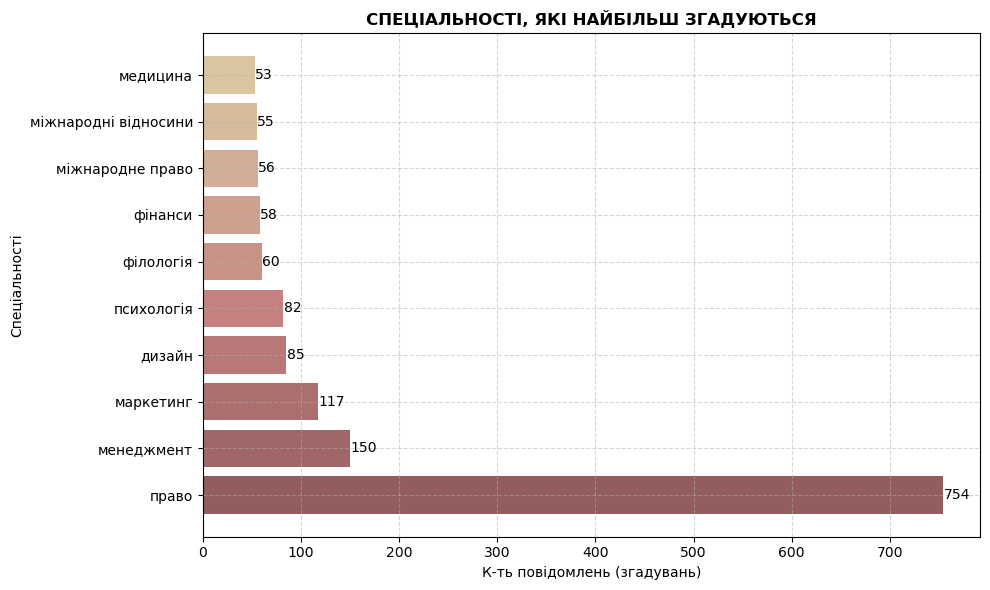

In [1598]:
colors = plt.cm.pink(np.linspace(0.2, 0.6, len(specialty_names)))  

plt.figure(figsize=(10, 6))

plt.barh(specialty_names, mention_counts_values, color=colors)

plt.title('СПЕЦІАЛЬНОСТІ, ЯКІ НАЙБІЛЬШ ЗГАДУЮТЬСЯ', fontweight='bold')
plt.xlabel('К-ть повідомлень (згадувань)')
plt.ylabel('Спеціальності')
plt.grid(True, linestyle='--', alpha=0.5)

for i, count in enumerate(mention_counts_values):
    plt.text(count + 0.5, i, str(count), va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

**ВИСНОВОК:** Право, менеджмент і маркетинг — це спеціальності, яким надають перевагу вступники, що підтверджується частими згадками в чатах абітурієнтів. Інші спеціальності, представлені на графіку, також демонструють значний інтерес серед вступників і є популярним вибором для навчання на бакалавраті.

Це свідчить про високу кореляцію між активністю абітурієнтів у чатах та реальними рейтингами популярності спеціальностей. Згадки в чатах можна використовувати як додаткове джерело даних для аналізу тенденцій і уподобань вступників, що дає змогу точніше прогнозувати попит на певні напрями.

## **ТЕМИ ОБГОВОРЕННЯ**

## 15. Популярність тем обговорення 

In [1612]:
search_phrases = {}

In [1614]:
with open(categ_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        if ':' in line.strip():
            key, phrases = line.strip().split(':', 1) 
            phrases_list = [phrase.strip() for phrase in phrases.split(',')]
            search_phrases[key.strip()] = phrases_list
        else:
            print(f"Пропущено рядок: {line.strip()}")  

word_counts = {group: 0 for group in search_phrases}

Пропущено рядок: 
Пропущено рядок: 
Пропущено рядок: 
Пропущено рядок: 


In [1616]:
for group, phrases in search_phrases.items():
    for phrase in phrases:
        word_counts[group] += all_text.count(phrase.lower())

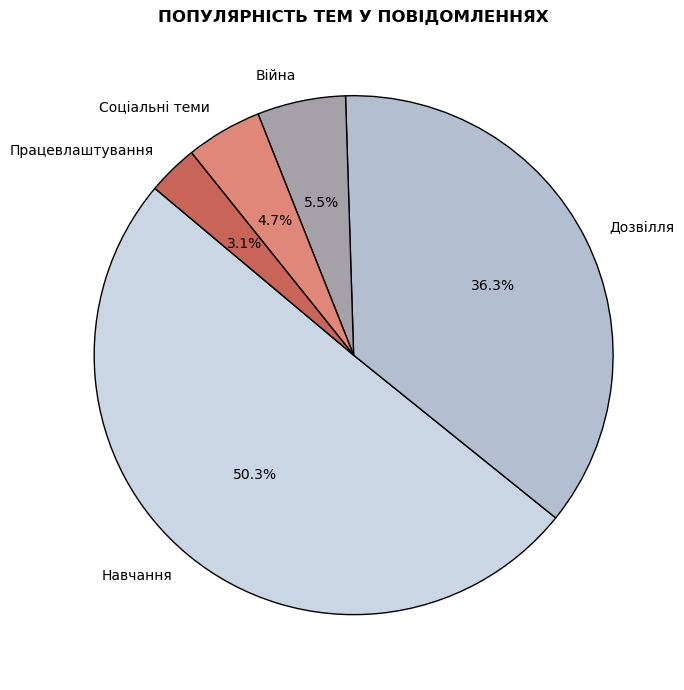

In [1627]:
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

labels = list(sorted_word_counts.keys())
sizes = list(sorted_word_counts.values())

plt.figure(figsize=(7, 7))
plt.pie(sizes, 
        labels=labels, 
        autopct='%1.1f%%', 
        startangle=140, 
        colors = ["#cbd6e4", "#b3bfd1", "#a4a2a8", "#df8879", "#c86558"], 
        wedgeprops={'edgecolor': 'black'})

plt.title('ПОПУЛЯРНІСТЬ ТЕМ У ПОВІДОМЛЕННЯХ',fontweight='bold')
plt.axis('equal') 

plt.tight_layout()
plt.show()

**ВИСНОВОК:** Аналіз показав, що 50% повідомлень у чатах абітурієнтів стосуються тем навчання та підготовки до іспитів. Це свідчить про те, що такі чати дійсно виконують свою основну функцію – слугують платформою для обговорення освітніх питань.

Цей показник є дуже позитивним, адже він демонструє, що в цих чатах переважає цільовий контент, а не лише спам чи обговорення сторонніх тем. Абітурієнти активно діляться інформацією, задають питання та отримують корисні відповіді, що сприяє їхній підготовці до вступу. Таким чином, чати абітурієнтів стають важливим інструментом підтримки та взаємодопомоги серед учасників.

## 16. ТОП-10 посилань 

In [1252]:
url_pattern = re.compile(r'https?://(?:www\.)?([\w.-]+)/?')

domain_counts = Counter()

In [1253]:
for message in df['message']:
    if pd.notnull(message):
        urls = url_pattern.findall(message)
        domain_counts.update(urls)

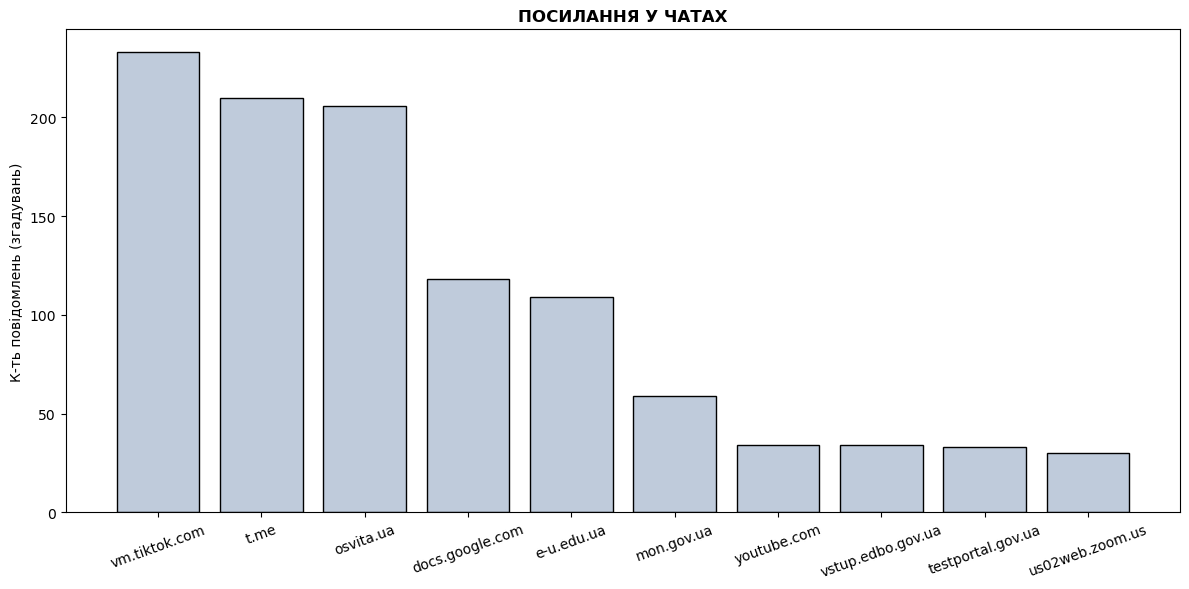

In [1643]:
top_domains = domain_counts.most_common(10)  
domains, counts = zip(*top_domains)

plt.figure(figsize=(12, 6))
plt.bar(domains, counts, color='#bfcbdb', edgecolor='black')

plt.title('ПОСИЛАННЯ У ЧАТАХ',fontweight='bold')
plt.ylabel('К-ть повідомлень (згадувань)')
plt.xticks(rotation=20)
plt.tight_layout()

plt.show()

 **ВИСНОВОК:** Згідно з діаграмою, найбільша кількість посилань у чатах абітурієнтів веде на TikTok, що може свідчити про популярність цієї платформи серед молоді навіть у час підготовки до іспитів. В загальному ці посилання можна розділити на теми, які згадувалися у п.15: 
 - Навчання (osvita.ua, e-u.edu.ua, mon.gov.ua, vstup.edbo.gov.ua, testportal.gov.ua) - тобто 50%, що відповідає аналізу пунктом вище.
 - Дозвілля та інше (vm.tiktok.com, t.me, docs.google.com, youtube.com, us02web.zoom.us).

## 17. Країни, що найчастіше згадуються

У цьому пункті аналізується частота згадування країн між абітурієнтами, що охоплює як зацікавленість підлітків навчанням за кордоном, так і обговорень актуальних тем у світі, що стосується міжнародних відносин.

In [1645]:
countries = {
    "США": r"\bсша\b|\bамерик(а|анський|анські|анська|анців|анці)\b",
    "Росія": r"\bросі(я|йський|йські|йська|ян|янський)\b",
    "Німеччина": r"\bнімечч(ина|ини|инці|анський|анська)\b",
    "Франція": r"\bфранц(ія|узький|узька|узькі|узьців|узьці)\b",
    "Польща": r"\bпольщ(а|і|і)\b|\bполяк(и|ів|ський|ська)\b",
    "Китай": r"\bкита(й|йський|йські|йців|йці)\b",
    "Італія": r"\bіталі(я|йський|йські|йська)\b",
    "Велика Британія": r"\b(велик(а|ої) британ(ія|ський|ські|ська|ці|ців)|англі(я|йці))\b",
    "Канада": r"\bканад(а|ський|ські|ська|ців|ці)\b",
    "Іспанія": r"\bіспан(ія|ський|ські|ська|ців|ці)\b",
    "Японія": r"\bяпон(ія|ський|ські|ська|ців|ці)\b",
    "Швеція": r"\bшвед(ія|ський|ські|ська|ці|ців)\b",
    "Швейцарія": r"\bшвейцар(ія|ський|ські|ська|ці|ців)\b",
    "Білорусь": r"\bбілорус(ь|і|ький|ька|ькі|ьців|ьці)\b",
    "Південна Корея": r"\bпівденн(а|ої) коре(я|йський|йські|йська|йців|йці)\b",
    "Фінляндія": r"\bфінлянді(я|йський|йські|йська|йців|йці)\b",
}

In [1647]:
country_mentions = Counter()

In [1649]:
for message in df['message']:
    if pd.notnull(message):
        for country, pattern in countries.items():
            if re.search(pattern, message):
                country_mentions[country] += 1

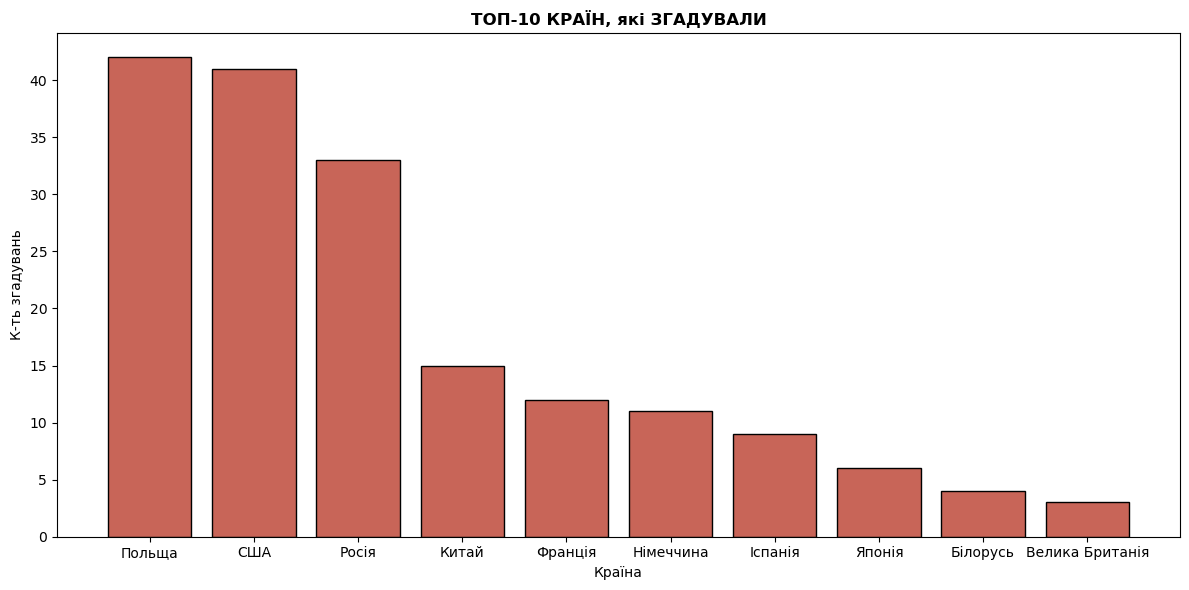

In [1657]:
top_countries = country_mentions.most_common(10)
country_names, counts = zip(*top_countries)

plt.figure(figsize=(12, 6))
plt.bar(country_names, counts, color='#c86558', edgecolor='black')

plt.title('ТОП-10 КРАЇН, які ЗГАДУВАЛИ', fontweight='bold')
plt.xlabel('Країна')
plt.ylabel('К-ть згадувань')
plt.xticks()
plt.tight_layout()

plt.show()

**ВИСНОВОК:** Польща, США та Росія входять до трійки найбільш згадуваних країн у чатах абітурієнтів, що свідчить про зацікавленість молоді в подіях, які відбуваються у світі (п. 15). Крім того, популярність країн може вказувати на вибір абітурієнтів щодо навчання за кордоном, зокрема в контексті доступних освітніх можливостей та міжнародних зв'язків.

## 18. Динаміка обговорення актуальних тем у країні

Посилаючись на п. 15 та додатковий аналіз поширених слів, було виявлено, що абітурієнти часто обговорюють актуальні події в Україні, зокрема щодо війни, що, безсумнівно, впливає на освітні закони та процеси навчання. Це свідчить про те, що ситуація в країні має значний вплив на навчальний процес і плани молоді. Тому було прийнято рішення проаналізувати динаміку обговорення важливих тем в Україні з 2022 по 2024 рік.

In [1265]:
with open(warwords_PATH, 'r', encoding='utf-8') as file:
    search_words = [line.strip().lower() for line in file.readlines()]
    
total_counts_by_year = {2022: 0, 2023: 0, 2024: 0}

In [1266]:
for file_name in os.listdir(DIALOGS_DATA_PATH):
    if file_name.endswith('.csv'):
        file_path = os.path.join(DIALOGS_DATA_PATH, file_name)
        df = pd.read_csv(file_path)

        if 'date' in df.columns and 'message' in df.columns:
            df['date'] = pd.to_datetime(df['date'], errors='coerce')  
            df['message'] = df['message'].apply(lambda x: re.sub(r'[^\w\s-]', '', str(x).lower()))  

            for _, row in df.iterrows():  
                message = row['message']
                timestamp = row['date']
                if pd.notnull(timestamp):  
                    year = timestamp.year
                    if year in [2022, 2023, 2024]:  
                        if any(re.search(r'\b' + re.escape(word) + r'\b', message) for word in search_words):
                            total_counts_by_year[year] += 1

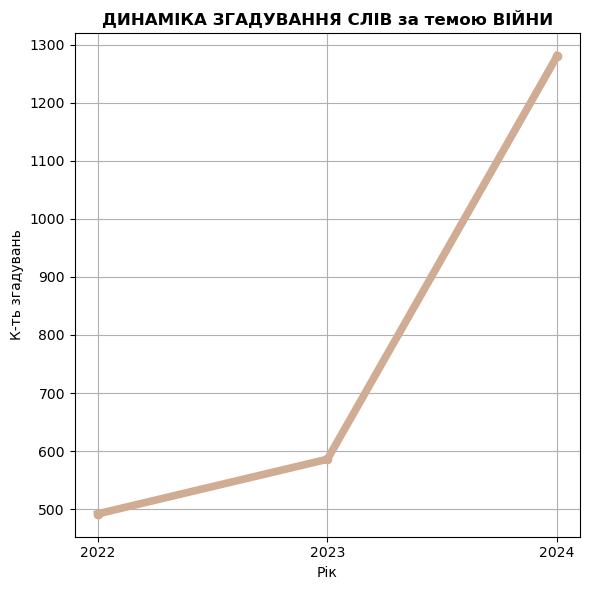

In [1673]:
df_result = pd.DataFrame(list(total_counts_by_year.items()), columns=['Рік', 'Кількість згадувань'])

plt.figure(figsize=(6, 6))
plt.plot(df_result['Рік'], df_result['Кількість згадувань'], marker='o', linestyle='-', color=plt.cm.pink(0.5), linewidth=5.5)

plt.title('ДИНАМІКА ЗГАДУВАННЯ СЛІВ за темою ВІЙНИ', fontweight='bold')
plt.xlabel('Рік')
plt.ylabel('К-ть згадувань')
plt.xticks([2022, 2023, 2024])
plt.grid(True)

plt.tight_layout()
plt.show()

**ВИСНОВОК:** Графік показує монотонне зростання з 2022 по 2024 рік, що свідчить про те, що інтерес і обізнаність серед молоді не зменшуються, а, навпаки, зростають. Це є позитивним показником підвищення рівня свідомості серед громадян України, що свідчить про їхню активну участь у обговореннях важливих соціальних та політичних тем.

## **МОВНЕ ПИТАННЯ**

## 19. Розподіл мов у чатах

Продовжуючи підсумки п. 18, було вирішено проаналізувати розподіл мов у чатах. Цей аналіз дозволяє зрозуміти, якими мовами спілкуються абітурієнти, що може відображати вплив мовної політики на взаємодію серед молоді.

In [1272]:
def clean_text(text):
    return re.sub(r"[^\wіїєґІЇЄҐа-яА-ЯёЁa-zA-Z ]", "", text)

In [1273]:
def detect_language(word):
    ukr_letters = set("іїєґІЇЄҐ")
    rus_letters = set("ыэёъЫЭЁЪ")
    eng_letters = set("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")

    if any(char in ukr_letters for char in word):
        return "Українська"
    elif any(char in rus_letters for char in word):
        return "Російська"
    elif all(char in eng_letters for char in word) and len(word) > 1:
        return "Англійська"
    return "Інша"

In [1274]:
all_words = []

In [1275]:
if 'message' in df.columns:
    df = df[df['message'].notna()]
    df['message'] = df['message'].astype(str).apply(clean_text)

In [1276]:
 words = " ".join(df['message']).split()
 words = [word for word in words if len(word) > 1]  
 all_words.extend(words)

In [1277]:
language_counts = Counter(detect_language(word) for word in all_words)

filtered_counts = {lang: language_counts[lang] for lang in ["Українська", "Російська", "Англійська"]}
total_filtered = sum(filtered_counts.values())

normalized_percentages = {lang: (count / total_filtered) * 100 for lang, count in filtered_counts.items()}

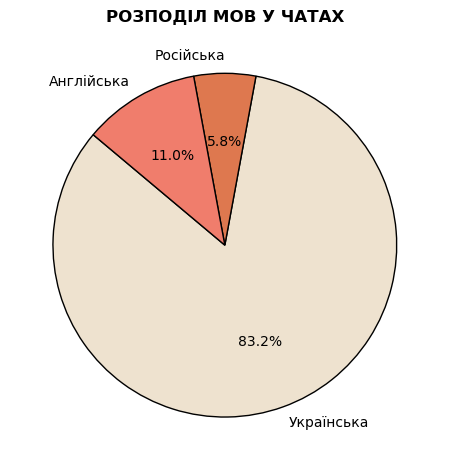

In [1681]:
plt.pie(
    normalized_percentages.values(),
    labels=normalized_percentages.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=['#EEE2CF', '#DE784F', '#F07D6C'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title("РОЗПОДІЛ МОВ У ЧАТАХ", fontweight='bold')
plt.tight_layout()
plt.show()

**ВИСНОВОК:** Українська мова має велику перевагу над іншими двома — англійською та російською. Це свідчить про підвищену популярність та значення української мови серед молоді, зокрема у контексті національної ідентичності. 

## 20. Розподіл мов у чатах (порівняння)

Продовжуючи п. 19, проведемо аналіз, як змінилася частка вживання російської та української мов у чатах абітурієнтів. Це дозволить зрозуміти, чи є тенденція до збільшення використання української мови, що може бути результатом посилення національної свідомості та підтримки української культури, особливо в умовах війни.

In [1683]:
all_words_2022_2023 = []
all_words_2024 = []

In [1685]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_2022_2023 = df[df['date'].dt.year.isin([2022, 2023])]
df_2024 = df[df['date'].dt.year == 2024]

In [1687]:
words_2022_2023 = " ".join(df_2022_2023['message']).split()
words_2024 = " ".join(df_2024['message']).split()

words_2022_2023 = [word for word in words_2022_2023 if len(word) > 1]
words_2024 = [word for word in words_2024 if len(word) > 1]

all_words_2022_2023.extend(words_2022_2023)
all_words_2024.extend(words_2024)

In [1689]:
def get_language_counts(words):
    language_counts = Counter(detect_language(word) for word in words)
    filtered_counts = {lang: language_counts[lang] for lang in ["Українська", "Російська", "Англійська"]}
    total_filtered = sum(filtered_counts.values())
    return {lang: (count / total_filtered) * 100 for lang, count in filtered_counts.items()}

In [1691]:
percentages_2022_2023 = get_language_counts(all_words_2022_2023)
percentages_2024 = get_language_counts(all_words_2024)

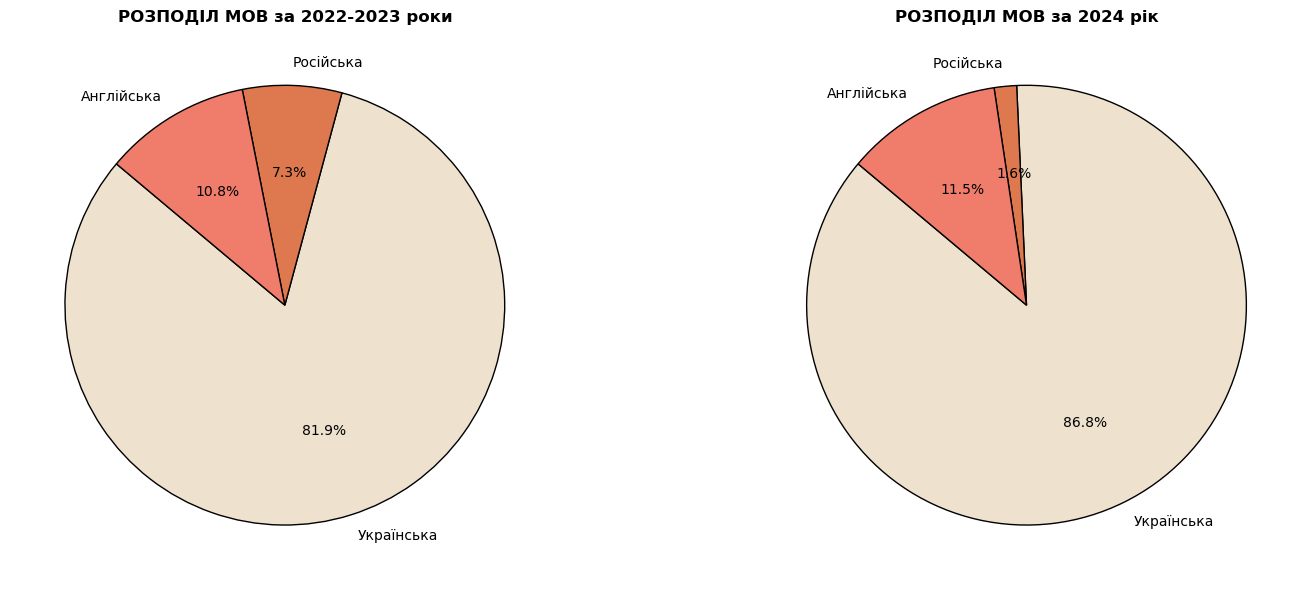

In [1705]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].pie(
    percentages_2022_2023.values(),
    labels=percentages_2022_2023.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=['#EEE2CF', '#DE784F', '#F07D6C'],
    wedgeprops={'edgecolor': 'black'}
)
ax[0].set_title("РОЗПОДІЛ МОВ за 2022-2023 роки", fontweight='bold')

ax[1].pie(
    percentages_2024.values(),
    labels=percentages_2024.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=['#EEE2CF', '#DE784F', '#F07D6C'],
    wedgeprops={'edgecolor': 'black'}
)
ax[1].set_title("РОЗПОДІЛ МОВ за 2024 рік", fontweight='bold')

plt.tight_layout()
plt.show()

**ВИСНОВОК:** Частка російської мови протягом трьох років (2022, 2023, 2024) у чатах абітурієнтів зменшилася в 4,5 рази, що свідчить про поступову відмову від її використання серед молоді. У той же час, частка англійської мови змінилася незначно, зростаючи лише на 1%, що може вказувати на стабільний інтерес до міжнародної комунікації та освіти за кордоном, але без значних коливань у використанні цієї мови.